## Лабораторна робота №2: "Імплементація алгоритмів стиснення"

Склад команди та розподіл виконаних завдань:
Валігурський Антон, Денисова Ірина, Кравчук Андрій
- Валігурський Антон - lzw, deflate
- Денисова Ірина - lz77
- Кравчук Андрій - haffman 

Для кожного з алгоритмів поданих нижче
- опишіть як працює алгорит
- напишіть класи з методами encode та decode
- перевірте правильність кодування та декодування
- дослідіть час виконання коду в залежності від розмірів вхідних даних
- оцініть ступінь стиснення(у відсотка) в залежності від розмірів
- напишіть висновок про ефективність різних алгоритмів та умови за яких той чи інший алгоритм дають кращий результат

In [126]:
import random, string
import matplotlib.pyplot as plt
from time import time

def randomword(length):
   letters = string.ascii_lowercase
   return ''.join(random.choice(letters) for i in range(length))

lengths = range(2,10001, 1000)


# Алгоритм Гаффмана

В цьому алгоритмі доцільно імплементувати клас node та додаткові функції в Huffman для побудови дерева кодування

In [127]:
class Huffman:
    def encode(self, text: str) -> tuple[str, dict[str, str]]:
        probabilities = {
            char: float(f"{text.count(char) / len(text):.3f}") for char in text
        }
        tree = sorted(probabilities.items(), key=lambda pair: pair[1], reverse=True)

        tree_hist = [tree]

        while not len(tree_hist) or len(tree_hist[-1]) != 2:
            new_entry = tree_hist[-1][:]
            last_el = new_entry.pop(-1)
            new_entry[-1] = (new_entry[-1][0], last_el[0]), new_entry[-1][1] + last_el[
                1
            ]
            new_entry.sort(key=lambda pair: pair[1], reverse=True)
            tree_hist.append(new_entry)

        coding_dict = {tree_hist[-1][0]: "1", tree_hist[-1][1]: "0"}

        tree_hist = tree_hist[::-1][1:]

        for node in tree_hist:
            for key, value in coding_dict.items():
                if key not in node:

                    for pair in node:
                        if pair[0] == key[0][0]:
                            left_prob = pair[1]
                        elif pair[0] == key[0][1]:
                            right_prob = pair[1]

                    coding_dict[(key[0][0], left_prob)] = value + "1"
                    coding_dict[(key[0][1], right_prob)] = value + "0"
                    coding_dict.pop(key)
                    break

        for char, code in coding_dict.items():
            text = text.replace(char[0], code)

        coding_dict = {pair[0]: value for pair, value in coding_dict.items()}

        return text, coding_dict

    def decode(self, code: str, coding_dict: dict[str, str]):
        decoded = ''
        curr_code = ''
        for bit in code:
            curr_code += bit
            for char, code in coding_dict.items():
                if code == curr_code:
                    decoded += char
                    curr_code = ""
                    break
        return decoded

# Алгоритм LZW

In [128]:
class LZW:
    def encode(self, text: str) -> tuple[str, list]:
        i = 0
        len_ = len(text)
        code = []

        start_dict = list(set(text))
        dict_ = start_dict[:]

        new_entry = ""
        while i < len_:
            new_entry += text[i]
            i += 1
            if new_entry not in dict_:
                dict_.append(new_entry)
                code.append(dict_.index(new_entry[:-1]))
                new_entry = ""
                i -= 1
                
        if new_entry not in dict_:
            dict_.append(new_entry)
        code.append(dict_.index(new_entry))
        
                
        return code, start_dict

        
    def decode(self, code: str, coding_dict: list) -> str:
        decoded_text = ""
        i = 0

        for symb in code:
            symb = int(symb)
            if int(symb) >= len(coding_dict):
                while len(coding_dict) <= symb:
                    new_entry = decoded_text[i]
                    i += 1
                    while i < len(decoded_text) and new_entry in coding_dict:
                        new_entry += decoded_text[i]
                        i += 1
                    if new_entry in coding_dict:
                        for new_char in new_entry:
                            new_entry += new_char
                            i+=1
                            if new_entry not in coding_dict:
                                break

                    coding_dict.append(new_entry)
                    i -= 1
            decoded_text += coding_dict[symb]

        return decoded_text







# Алгоритм LZ77

Потрібно заміряти розміри саме тексту, проте для роботи доцільно використовувати список тюплів, тому для зручності варто імплементувати додаткові алгоритми _text2list та _list2text

In [129]:
class LZ77:
    def __init__(self, window_size: int):
        self.window_size = window_size

    def encode(self, text):
        """
        Encoding
        """
        compressed = []
        index = 0

        while index < len(text):
            best_offset = -1
            best_length = -1
            best_match = ''

            # Search for the longest match in the sliding window
            for length in range(1, min(len(text) - index, self.window_size)):
                substring = text[index:index + length]
                offset = text.rfind(substring, max(0, index - self.window_size), index)

                if offset != -1 and length > best_length:
                    best_offset = index - offset
                    best_length = length
                    best_match = substring

            if best_match:
                # Add the (offset, length, next_character) tuple to the compressed data
                compressed.append((best_offset, best_length, text[index + best_length]))
                index += best_length + 1
            else:
                # No match found, add a zero-offset tuple
                compressed.append((0, 0, text[index]))
                index += 1

        return compressed

    def decode(self, encoded_list: list) -> str:
        """
        Decoding
        """
        result = ""
        for item in encoded_list:
            offset, length, next_char = item
            result += result[-offset:][:length] + next_char
        return result


# Алгоритм Deflate

In [130]:
class Deflate:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size

    def encode(self, text: str) -> str:


        huff_encoded, codes_dict = Huffman().encode(text)
        enccoded = LZ77(self.buffer_size).encode(huff_encoded)
        
        return enccoded,codes_dict

                
    def decode(self, code: list, codes: dict) -> str:

        return Huffman().decode(LZ77(self.buffer_size).decode(code),codes)

    
text = "zxcsafdasfkasfasf;lasfdlkjasfdl;asf;ld"
deflate = Deflate(5)

encoded_text, codes_dict=deflate.encode(text)
decoded = deflate.decode(encoded_text, codes_dict)
print(decoded)



zxcsafdasfkasfasf;lasfdlkjasfdl;asf;ld


# Testing

LZW effectivenes: 0.5
LZ77 effectiveness: 0.1111111111111111
HUFFMAN coding enlargement: 1.0
DEFLATE effectivenes: 0.1

LZW effectivenes: 0.7313868613138687
LZ77 effectiveness: 0.13222486144101345
HUFFMAN coding enlargement: 4.719560878243513
DEFLATE effectivenes: 0.023528306760278957

LZW effectivenes: 0.7966573816155988
LZ77 effectiveness: 0.13069591330460895
HUFFMAN coding enlargement: 4.742257742257742
DEFLATE effectivenes: 0.02342287532759266

LZW effectivenes: 0.8569797316585783
LZ77 effectiveness: 0.13225834875319412
HUFFMAN coding enlargement: 4.7405063291139244
DEFLATE effectivenes: 0.02343390187736622

LZW effectivenes: 0.9128649635036497
LZ77 effectiveness: 0.13245953728527454
HUFFMAN coding enlargement: 4.750624687656172
DEFLATE effectivenes: 0.023385183540383558

LZW effectivenes: 0.91931630215034
LZ77 effectiveness: 0.13213927193955724
HUFFMAN coding enlargement: 4.7451019592163135
DEFLATE effectivenes: 0.02341310890699819

LZW effectivenes: 0.9379590561025161
LZ77 effect

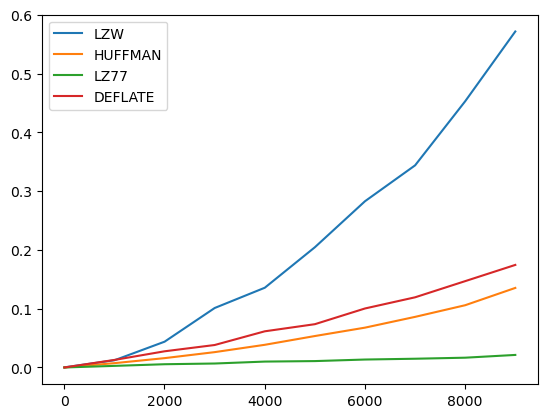

In [131]:
X = [i for i in lengths]
Y_LZW = []
Y_HUFFMAN = []
Y_LZ77 = []
Y_DEFLATE = []

for i in lengths:

    to_code = randomword(i)
    start = time()
    code, dict_ = LZW().encode(to_code)
    decoded = LZW().decode(code, dict_)
    Y_LZW.append(time()-start)
    assert to_code == decoded
    
    print("LZW effectivenes:",i / (len(code) + len(dict_)))
    
    start = time()
    lz777 = LZ77(5)
    encoded = lz777.encode(to_code)
    decoded = lz777.decode(encoded)
    Y_LZ77.append(time()-start)
    assert decoded == to_code
    
    print("LZ77 effectiveness:", i / (9*len(encoded)))
    
    start = time()
    huff = Huffman()
    encoded, coding_dict = huff.encode(to_code)
    decoded = huff.decode(encoded,coding_dict)
    Y_HUFFMAN.append(time()-start)
    assert to_code == decoded
    
    print("HUFFMAN coding enlargement:", len(encoded) / i)


    start = time()
    deflate = Deflate(5)
    encoded_text, codes_dict=deflate.encode(to_code)
    decoded = deflate.decode(encoded_text, codes_dict)
    Y_DEFLATE.append(time()-start)
    assert to_code == decoded
    print("DEFLATE effectivenes:", i / (len(encoded) * 9 + len(codes_dict)))


    print()
    
    
    
plt.plot(X, Y_LZW, label = "LZW")
plt.plot(X, Y_HUFFMAN, label = "HUFFMAN")
plt.plot(X, Y_LZ77, label = "LZ77")
plt.plot(X, Y_DEFLATE, label = "DEFLATE")
plt.xlabel = "length of string"
plt.ylabel = "time perfomance"

plt.legend()
plt.show()



# Huffman
Метод encode закодовує текст за допомогою двійкової системи числення. За допомогою алгоритму Гаффмана можна побудувати дерево Гаффмана(оптимального коду). Злиття полягає в побудові нового дерева із двох наявних дерев (або листків) із найменшими ймовірностями. При цьому листок або дерево з більшою ймовірністю завжди утворює ліве піддерево, а сума ймовірностей лівого й правого піддерев дорівнює ймовірності отриманого дерева (її записують у корінь). Поміщають 0 на ребро до лівого піддерева, 1 – на ребро до правого піддерева. Перед кожним злиттям імовірності упорядковують за спаданням. Отримуємо закодований у двійковій системі текст.

Метод decode розкодовує текст, для розкодування метод потребує список з символами та їх кодами. Алгоритм проходиться по всьому тексту, записуючи 0 та 1, поки ця послідовність не буде відповідати закодованому символу. Отримуємо розкодований текст.

Алгоритм Гаффмана належить до жадібних алгоритмів. Також закодований текст у вигляді двійкового коду буде в рази довший за розкодований текст, адже вдвійковій системі є лише два символи - 1 і 0.

### LZW
Алгоритм працює тим, що створює словник коду, шукаючи підпослідовності, які ще в ноьому не наявні. Кожен раз коли ми знаходимо підрядок якого ще немає, ми записуємо його під новим індексом, та додаємо в код індекс підрядку з якого починається новий підрядок. Так отримуємо код з цифр. Для розкодування отримувач має код з чисел та словник унікальних символів. Розкодовуєтсья за тим же принципом, що і кодується, лише тепер нам треба відтворювати словник.

Очевидно, що зі зростанням кількості елементів в повідомленні, час стиснення відповідно зростає. На жаль, через повільнісь мови програмування Python нам не вдастся перевірити ефективність стиснення на повну, адже алгоритм розкриваєтсья на повну потужність на великих файлах, таких як картинки, в яких дуже багато повторен. Це можна довести тим, що зі збільшенням елементів відслідковується збільшення ефективності стиснення.


# LZ77
Метод encode сканує текст та створює стиснену версію, використовуючи трійки (зсув, довжина, наступний символ). Для кожної позиції у тексті, алгоритм шукає найдовший збіг вікном заданого розміру, позначає його як трійку і зсувається далі. Якщо збіг не знайдено, то додається трійка з нульовим зсувом.

Метод decode використовує закодовані трійки для відновлення оригінального тексту. Для кожної трійки він використовує зсув та довжину для вибору підстрічки з попередніх символів та додає наступний символ.

Н амою думку, цей алгоритм ефективно стискує повторювані фрагменти в тексті, зменшуючи загальний об'єм інформації. Однак для деяких видів даних та текстів інші алгоритми стиснення можуть бути більш ефективними.

# DEFLATE
Динамічний алгоритм стиснення, який одночасно закодовує повідомлення за допомогою алгоритму Гафмана, а потім стискає за допомогою алгоритму LZ77. Алгоритм є динамічним, тому він може міняти порядок використаних алгоритмів, підбирати словники кодів, для досягнення найменшого збільшення. На жаль, через те, що пайтон дуже повільний, ми не зможемо розкрити повний потенціал цього алгоритму. Адже deflate краще всього розкриваєтсья на справжніх файлах та великих даних. Адже після того як ми перетворимо наше повідомлення в двійковий код, LZ77 буде працювати в рази краще, через те що повторів буде більше, адже повідмолення скаладитемться лише з 0 та 1.

# SUMMARY

Загалом можна побачити, що Huffman працює швидше за всіх. Це пов'язано з тим, що він виконує мінімальну кількість конкатинацій по стрічці, адже йому треба тільки зібрати вірогідності появи кожного зі слів(елементарних одиниць повідомлення). Порівнювати його роботу з ішими алгоритмами немає сенсу, адже в них різне призначення.

LZW - показав найкраще стиснення, хоча повідомлення ставало тільки більше. Це пов'язано з тим, що він працює краще всього з картинками. Там багато повторень. Працює повільніше за всіх, через те, що там більше всього ітерацій по повідомленню.

LZ77 - Працює швидше всіх імплементованих алгоритмів стиснення, тому що має буфер та одноразову ітерацію по повідомленню. Краще всього використовувати на реальних файлах.

Deflate - Алгоритм зявдяки якому ми завдячуємо gzip'y та швидкому інтернету. Також краще всього працює на реальних даних.